In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
from scipy.signal import argrelextrema, find_peaks
# import cufflinks as cf
# import plotly as py

### Download data


In [ ]:
exchange_id = "binance"
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({})
exchange.id

In [ ]:
# check exchange has fetch_ohlcv
exchange.has["fetchOHLCV"]

In [2]:
symbol = "BTCUSDT"
timeframe = "1d"

In [ ]:
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=1000)
ohlcv

In [ ]:
df = pd.DataFrame(ohlcv, columns=["Date", "Open", "High", "Low", "Close", "Volume"])
df

In [ ]:
df["Date"] = pd.to_datetime(df["Date"], unit='ms')
df = df.set_index("Date")
df

In [ ]:
df.to_csv(f'./data/btcusdt{timeframe}.csv')

In [3]:
df = pd.read_csv(f"./data/btcusdt{timeframe}.csv", index_col=["Date"], parse_dates=["Date"])
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-10-15,26852.48,27293.33,26808.25,27154.15,15274.69170
2023-10-16,27154.14,30000.00,27112.66,28500.78,78399.22445
2023-10-17,28500.77,28613.65,28069.32,28395.91,38428.44532
2023-10-18,28395.91,28982.36,28142.87,28320.00,32162.47591
2023-10-19,28320.00,28916.89,28100.66,28713.71,35895.50179
...,...,...,...,...,...
2025-02-21,98305.01,99475.00,94871.95,96181.98,32249.28140
2025-02-22,96181.99,96980.00,95770.49,96551.01,11268.17708
2025-02-23,96551.01,96650.00,95227.94,96258.00,10884.84913


### `ZigZag` algorithm with `Argrelextrema` (rolling, for loop...)


29


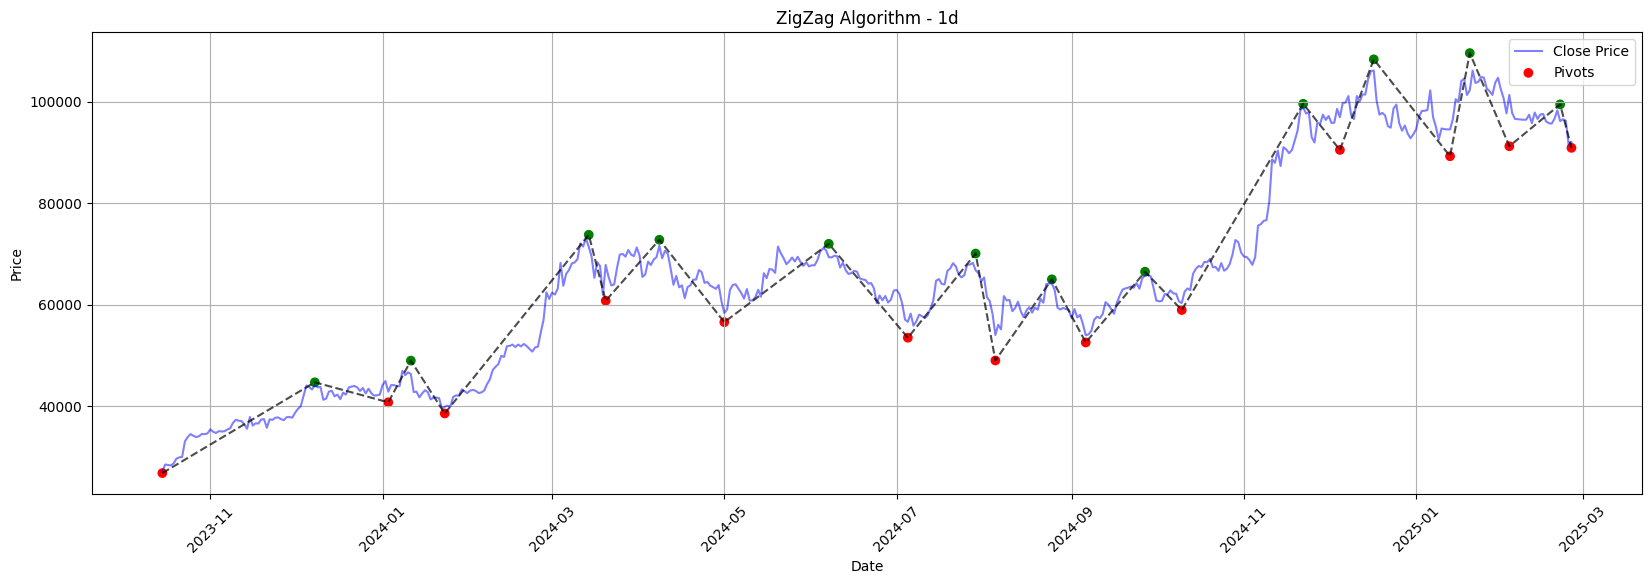

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

class ZigZag:
    def __init__(self, dev_threshold=5.0, depth=10):
        self.dev_threshold = dev_threshold / 100  # Convert percentage to decimal
        self.depth = depth
        self.pivots = []

    def find_pivots(self, highs, lows):
        pivots = []
        # find peaks
        peak_indexes = argrelextrema(highs, np.greater_equal, order=self.depth)[0]
        pivots.extend([pivot for pivot in zip(peak_indexes, highs[peak_indexes], ["High"] * len(peak_indexes))])
        # find valleys
        valley_indexes = argrelextrema(lows, np.less_equal, order=self.depth)[0]
        pivots.extend([pivot for pivot in zip(valley_indexes, lows[valley_indexes], ["Low"] * len(valley_indexes))])
        return sorted(pivots)

    def apply_zigzag(self, df):
        # prices = df["Close"].values
        highs = df["High"].values
        lows = df["Low"].values
        detected_pivots = self.find_pivots(highs, lows)
        if not detected_pivots:
            return []

        print(len(detected_pivots))

        zigzag_points = [detected_pivots[0]]
        for i in range(1, len(detected_pivots)):
            last_pivot = zigzag_points[-1]
            current_pivot = detected_pivots[i]
            # If the new pivot has a different label (High/Low), check the price change
            if last_pivot[2] != current_pivot[2]:
                price_change = abs(current_pivot[1] - last_pivot[1]) / last_pivot[1]

                if price_change >= self.dev_threshold:
                    zigzag_points.append(current_pivot)
            # if current and last pivot have same label then check high or low
            else:
                if (len(zigzag_points) > 2):
                    second_last_pivot = zigzag_points[-2]
                    # Compare current pivot with the second-to-last pivot if labels are the same
                    price_change_new = abs(current_pivot[1] - second_last_pivot[1]) / second_last_pivot[1]
                    price_change_prev = abs(last_pivot[1] - second_last_pivot[1]) / second_last_pivot[1]
                    if price_change_new >= price_change_prev:
                        if current_pivot[2] == "High" and current_pivot[1] >= last_pivot[1]:
                            zigzag_points[-1] = current_pivot
                        elif current_pivot[2] == "Low" and current_pivot[1] <= last_pivot[1]:
                            zigzag_points[-1] = current_pivot

        self.pivots = [(df.index[i], price, label) for i, price, label in zigzag_points]  # Use index as datetime
        return self.pivots

    def plot(self, df):
        plt.figure(figsize=(20, 6))
        plt.plot(df.index, df["Close"], label="Close Price", color="blue", alpha=0.5)

        if self.pivots:
            pivot_dates, pivot_prices, pivot_labels = zip(*self.pivots)
            plt.scatter(pivot_dates, pivot_prices, c=["green" if label == "High" else "red" for label in pivot_labels], label="Pivots")
            plt.plot(pivot_dates, pivot_prices, color="black", linestyle="dashed", alpha=0.7)

        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.title(f"ZigZag Algorithm - {timeframe}")
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()


# Example usage
zigzag = ZigZag(dev_threshold=5, depth=10)
zigzag.apply_zigzag(df)
zigzag.plot(df)


### Directional Change Algorithm


### Compare logic and speed `rolling`, `argrelextrema` and `find_pivots` method


**Logic**


In [ ]:
order = 70

**Rolling**


In [ ]:
def rolling_find_pivots(depth, prices):
    pivots = []
    
    # Rolling max to find pivots 
    rolling_max = pd.Series(prices).rolling(depth*2, center=True).max()
    high_indexer = np.where(prices == rolling_max)[0]
    if (high_indexer):
        pivots.extend(high_indexer)

    for i in range(1, depth):
        if all(prices[i] >= prices[j] for j in range(i)) and all(prices[i] >= prices[i + j] for j in range(1, depth + 1)):
        # if np.all(prices[i] >= prices[:i]) and np.all(prices[i] >= prices[i + 1: i + depth + 1]):
            pivots.append(i)
        
    for i in range(len(prices) - depth, len(prices)):
        # if np.all(prices[i] >= prices[i - depth: i - 1]) and np.all(prices[i] >= prices[i + 1:]):
        if all(prices[i] >= prices[i - j] for j in range(1, depth + 1)) and all(prices[i] >= prices[j] for j in range(len(prices) - i, len(prices))):
            pivots.append(i)
    
    # Return indexer sorted
    return sorted(pivots)
    
rolling_find_pivots(70, df["Close"].to_numpy())
    

**Argrelextrema**


In [ ]:
argrelextrema(df["Close"].values, np.greater_equal, order=order)[0]

**for loop**


In [ ]:
# original loop
def find_pivots(depth: int, prices: np.array):
    # pivots = np.array([])
    pivots = []
    for i in range(1, len(prices)):
        # edge case for beginning values
        if i < depth:
            is_high = all(prices[i] >= prices[j] for j in range(i)) and \
                        all(prices[i] >= prices[i + j] for j in range(1, depth + 1))
        # edge case for last values
        elif i >= len(prices) - depth:
            is_high = all(prices[i] >= prices[i - j] for j in range(1, depth + 1)) and \
                        all(prices[i] >= prices[j] for j in range(len(prices) - depth, len(prices)))
        # compare depth of candle before and after the current candle
        else:            
            is_high = all(prices[i] >= prices[i - j] for j in range(1, depth + 1)) and \
                        all(prices[i] >= prices[i + j] for j in range(1, depth + 1))
        if is_high:
            # pivots = np.append(pivots, [i])
            pivots.append(i)
            
    return pivots

find_pivots(order, df["Close"].to_numpy())

**for loop with numpy**


In [ ]:
# numpy
def find_pivots_numpy(depth: int, prices: np.array):
    # pivots = np.array([])
    pivots = []

    for i in range(len(prices)):
        start = max(0, i - depth)
        end = min(len(prices), i + depth + 1)

        if np.all(prices[i] >= prices[start:i]) and np.all(prices[i] >= prices[i+1:end]):
            # pivots = np.append(pivots, [i])
            pivots.append(i)

    return pivots

find_pivots_numpy(order, df["Close"].to_numpy())

**for loop optimized**


In [ ]:
def find_pivots_optimized(depth, prices):
    # pivots = np.array([])
    pivots = []
    prices_len = len(prices)

    for i in range(prices_len):
        start = max(0, i - depth)  # Ensures we don’t go below index 0
        end = min(prices_len, i + depth + 1)  # Ensures we don’t exceed list length
        
        is_high = all(prices[i] >= prices[j] for j in range(start, i)) and \
                  all(prices[i] >= prices[j] for j in range(i + 1, end))

        if is_high:
            # pivots = np.append(pivots, [i])
            pivots.append(i)

    return pivots

find_pivots_optimized(order, df["Close"].to_numpy())

#### test speed


In [ ]:
from timeit import timeit

In [ ]:
rolling_time = timeit(lambda: rolling_find_pivots(order, df["Close"].to_numpy()), number=10000)
# argrelextrema_time = timeit(lambda: argrelextrema(df["Close"].to_numpy(), np.greater_equal, order=order), number=10000)
# find_pivots_time = timeit(lambda: find_pivots(order, df["Close"].to_numpy()), number=10000)
# find_pivots_numpy_time = timeit(lambda: find_pivots_numpy(order, df["Close"].to_numpy()), number=10000)
# find_pivots_optimized_time = timeit(lambda: find_pivots_optimized(order, df["Close"].to_numpy()), number=10000)

In [ ]:
print(f"Rolling: {rolling_time:.4f} sec")
# print(f"Argrelextrema: {argrelextrema_time:.4f} sec")
# print(f"Find pivots method: {find_pivots_time:.4f} sec")
# print(f"Find pivots numpy method: {find_pivots_numpy_time:.4f} sec")
# print(f"Find pivots optimized method: {find_pivots_optimized_time:.4f} sec")

https://stackoverflow.com/questions/62454181/zigzag-indicator-in-python


In [ ]:
def filter(values, percentage):
    previous = values[0] 
    mask = [True]
    for value in values[1:]: 
        relative_difference = np.abs(value - previous)/previous
        if relative_difference > percentage:
            previous = value
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
# Create zigzag trendline.
########################################
# Find peaks(max).
data_x = df.index.values
data_y = df['Close'].values
peak_indexes = argrelextrema(data_y, np.greater)
peak_indexes = peak_indexes[0]
# Find valleys(min).
valley_indexes = argrelextrema(data_y, np.less)
valley_indexes = valley_indexes[0]          
# Merge peaks and valleys data points using pandas.
df_peaks = pd.DataFrame({'date': data_x[peak_indexes], 'zigzag_y': data_y[peak_indexes]})
df_valleys = pd.DataFrame({'date': data_x[valley_indexes], 'zigzag_y': data_y[valley_indexes]})
df_peaks_valleys = pd.concat([df_peaks, df_valleys], axis=0, ignore_index=True, sort=True)
# Sort peak and valley datapoints by date.
df_peaks_valleys = df_peaks_valleys.sort_values(by=['date'])
p = 0.1 # 20% 
filter_mask = filter(df_peaks_valleys.zigzag_y, p)
filtered = df_peaks_valleys[filter_mask]

df_peaks_valleys[filter_mask]

https://stackoverflow.com/questions/59559788/pandas-zigzag-segmentation-of-data-based-on-local-minima-maxima


In [11]:
def directional_change(close: np.array, high: np.array, low: np.array, sigma: float):
    up_zig = True
    tmp_max = high[0]
    tmp_min = low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    # variable to store peaks and valleys zigzag line
    tops, bottoms = [], []

    for i in range(1, len(close)):
        if up_zig:
            if high[i] > tmp_max:
                tmp_max = high[i]
                tmp_max_i = i
            elif close[i] < tmp_max * (1 - sigma):
                tops.append([i, tmp_max_i, tmp_max])

                # setup for next bottom
                up_zig = False
                tmp_min = low[i]
                tmp_min_i = i
        else:
            if low[i] < tmp_min:
                tmp_min = low[i]
                tmp_min_i = i
            elif close[i] > tmp_min * (1 + sigma):
                bottoms.append([i, tmp_min_i, tmp_min])

                # setup for next top
                up_zig = True
                tmp_max = high[i]
                tmp_max_i = i
        
    return tops, bottoms

In [19]:
tops, bottoms = directional_change(df["Close"].to_numpy(), df["High"].to_numpy(), df["Low"].to_numpy(), 0.1)

In [20]:
df_peaks = pd.DataFrame(tops, columns=['index', "idx", "pivot"]).iloc[:, 1:]
df_peaks["label"] = ["High"] * len(df_peaks)
df_valleys = pd.DataFrame(bottoms, columns=['index', "idx", "pivot"]).iloc[:, 1:]
df_valleys["label"] = ["Low"] * len(df_valleys)
df_peak_valley = pd.concat([df_peaks, df_valleys])
df_peak_valley

,idx,pivot,label
0,88,48969.48,High
1,151,73777.00,High
2,176,72797.99,High
3,190,67232.35,High
4,236,71997.02,High
5,288,70079.99,High
6,315,65000.00,High
7,429,108353.00,High
8,463,109588.00,High
0,100,38555.00,Low


In [21]:
df_peak_valley["idx"].values

array([ 88, 151, 176, 190, 236, 288, 315, 429, 463, 100, 157, 187, 199,
       264, 295, 327, 442])

In [22]:
df.iloc[df_peak_valley["idx"].values].index

DatetimeIndex(['2024-01-11', '2024-03-14', '2024-04-08', '2024-04-22',
               '2024-06-07', '2024-07-29', '2024-08-25', '2024-12-17',
               '2025-01-20', '2024-01-23', '2024-03-20', '2024-04-19',
               '2024-05-01', '2024-07-05', '2024-08-05', '2024-09-06',
               '2024-12-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [23]:
df_peak_valley["Date"] = df.iloc[df_peak_valley["idx"].values].index
df_peak_valley = df_peak_valley.set_index("Date")
df_peak_valley = df_peak_valley.iloc[:, 1:]
df_peak_valley

,pivot,label
Date,,
2024-01-11,48969.48,High
2024-03-14,73777.00,High
2024-04-08,72797.99,High
2024-04-22,67232.35,High
2024-06-07,71997.02,High
2024-07-29,70079.99,High
2024-08-25,65000.00,High
2024-12-17,108353.00,High
2025-01-20,109588.00,High


In [24]:
df_peak_valley = df_peak_valley.sort_index()
df_peak_valley

,pivot,label
Date,,
2024-01-11,48969.48,High
2024-01-23,38555.00,Low
2024-03-14,73777.00,High
2024-03-20,60775.00,Low
2024-04-08,72797.99,High
2024-04-19,59600.01,Low
2024-04-22,67232.35,High
2024-05-01,56552.82,Low
2024-06-07,71997.02,High


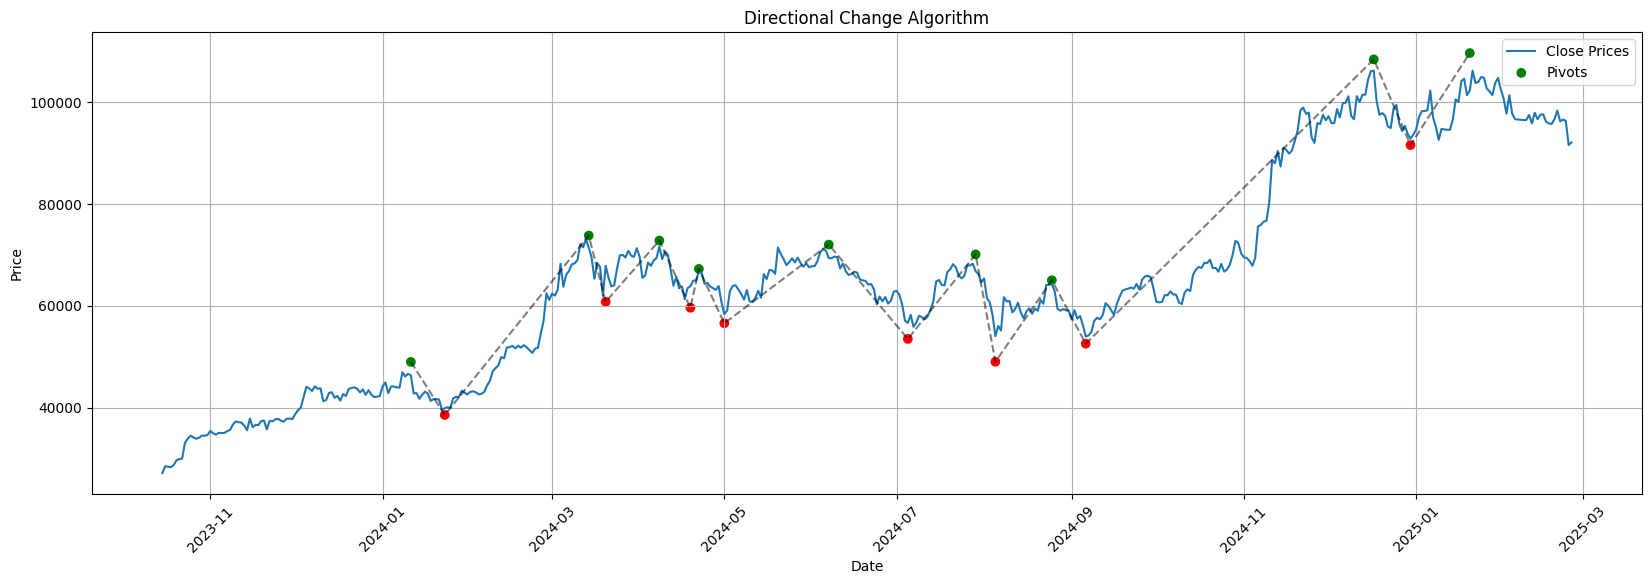

In [25]:
plt.figure(figsize=(20, 6))
plt.plot(df.index, df["Close"], label="Close Prices")
plt.scatter(df_peak_valley.index, df_peak_valley["pivot"], c=['green' if label == "High" else 'red' for label in df_peak_valley["label"]], label="Pivots")
plt.plot(df_peak_valley.index, df_peak_valley["pivot"], color="black", linestyle="dashed", alpha=0.5)

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.title("Directional Change Algorithm")
plt.grid()
plt.show()

### Identify resistance and support levels based on `Gaussian KDE` (like as Market Profile)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import talib as ta

def find_levels( 
        price: np.array, atr: float, # Log closing price, and log atr 
        first_w: float = 0.1, 
        atr_mult: float = 3.0, 
        prom_thresh: float = 0.1
):
    # Setup weights
    last_w = 1.0
    w_step = (last_w - first_w) / len(price)
    weights = first_w + np.arange(len(price)) * w_step
    weights[weights < 0] = 0.0

    # Get kernel of price. 
    kernal = scipy.stats.gaussian_kde(price, bw_method=atr*atr_mult, weights=weights)

    # Construct market profile
    min_v = np.min(price)
    max_v = np.max(price)
    # arange
    step = (max_v - min_v) / 200
    price_range = np.arange(min_v, max_v, step)
    # linspace
    # price_range = np.linspace(min_v, max_v, 200)
    pdf = kernal(price_range) # Market profile

    # Find significant peaks in the market profile
    pdf_max = np.max(pdf)
    prom_min = pdf_max * prom_thresh

    peaks, props = scipy.signal.find_peaks(pdf, prominence=prom_min)  # alternative ways: rolling/ argrelextrema
    levels = [] 
    for peak in peaks:
        levels.append(np.exp(price_range[peak]))

    return levels, peaks, props, price_range, pdf, weights

def support_resistance_levels(
        data: pd.DataFrame, lookback: int, 
        first_w: float = 0.01, atr_mult:float=3.0, prom_thresh:float =0.25
):

    # Get log average true range, 
    atr = ta.ATR(np.log(data['High']), np.log(data['Low']), np.log(data['Close']), lookback)

    all_levels = [None] * len(data)
    for i in range(lookback, len(data)):
        i_start  = i - lookback
        vals = np.log(data.iloc[i_start+1: i+1]['Close'].to_numpy())
        levels, peaks, props, price_range, pdf, weights= find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
        all_levels[i] = levels
        
    return all_levels

def sr_penetration_signal(data: pd.DataFrame, levels: list):
    signal = np.zeros(len(data))
    curr_sig = 0.0
    close_arr = data['Close'].to_numpy()
    for i in range(1, len(data)):
        if levels[i] is None:
            continue

        last_c = close_arr[i - 1]
        curr_c = close_arr[i]

        
        for level in levels[i]:
            if curr_c > level and last_c <= level: # Close cross above line
                curr_sig = 1.0
            elif curr_c < level and last_c >= level: # Close cross below line
                curr_sig = -1.0

        signal[i] = curr_sig
    return signal

def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    long_trades = []
    short_trades = []

    close_arr = data['Close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['percent'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price'] 
    short_trades['percent'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    return long_trades, short_trades 

if __name__ == '__main__':
   
    # Trend following strategy
    # data = pd.read_csv('BTCUSDT86400.csv')
    # data['date'] = data['date'].astype('datetime64[s]')
    # data = data.set_index('date')
    df = df.copy()
    plt.style.use('dark_background') 
    levels = support_resistance_levels(df, 365, first_w=1.0, atr_mult=3.0)

    df['sr_signal'] = sr_penetration_signal(df, levels)
    df['log_ret'] = np.log(df['Close']).diff().shift(-1)
    df['sr_return'] = df['sr_signal'] * df['log_ret']

    long_trades, short_trades = get_trades_from_signal(df, df['sr_signal'].to_numpy())



### Gaussian KDE Learning Crash


In [ ]:
import scipy
import talib as ta

In [ ]:
# log price
close = np.log(df.iloc[len(df) - 360:]["Close"].to_numpy())
atr = ta.ATR(np.log(df["High"].to_numpy()), np.log(df["Low"].to_numpy()), np.log(df["Close"].to_numpy()), 360)

In [ ]:
# weight parameter for gaussian
first_w = 0.1
last_w = 1.0
w_step = (last_w - first_w) / len(close)
weights = first_w + np.arange(len(close)) * w_step
weights[weights < 0] = 0.0

In [ ]:
def price_bin_arange(min, max):
    step = min * 1.00444444444 - min
    return np.round(np.arange(min, max, step=step), 2)

In [ ]:
df["DTO"] = df.apply(lambda row: price_bin_arange(row["Low"], row["High"]), axis=1)
df

In [ ]:
market_profile = np.concatenate(df["DTO"][:100].values)
market_profile.sort()
bias = np.diff(market_profile)
filtered_market_profile = market_profile[1:][bias > 100]

In [ ]:
# kde = scipy.stats.gaussian_kde(close, bw_method=(atr*3)[-1], weights=weights)
kde = scipy.stats.gaussian_kde(close)
x = np.linspace(close.min(), close.max(), 100)
# x = price_bin_arange(close.min(), close.max())
# x = np.log(market_profile)
# x = np.log(filtered_market_profile)
pdf = kde(x)

In [ ]:
# log price
plt.plot(np.exp(x), pdf, label="KDE")

#### find_peaks learning


In [ ]:
# Find peaks
prom_min = pdf.max() * 0.1
peaks, _ = find_peaks(pdf, prominence=prom_min)

In [ ]:
peaks

In [ ]:
price_levels = np.exp(x[peaks])

In [ ]:
plt.plot(np.exp(x), pdf, label="BTC Price")
plt.scatter(price_levels, pdf[peaks], color='red', label="Peaks", zorder=3)
plt.xlabel("Price")
plt.ylabel("Time")
plt.title("Detected Peaks in BTC Prices")
plt.legend()
plt.show()

In [ ]:
nearest_points = []
# tolerance = 5

for level in price_levels:
    # s_temp = df[df["Close"].between(level - tolerance, level + tolerance)]["Close"]
    point_idx = np.abs(df["Close"][len(df) - 360:] - level).idxmin()
    nearest_points.append(point_idx)

nearest_points

In [ ]:
plt.figure(figsize=(20, 8), facecolor="#000")  # Set figure background color
ax = plt.gca()  # Get current axes
ax.set_facecolor("#000")  # Set plot background color

plt.plot(df.index, df["Close"], label="Price", color="#FFB22C")
plt.hlines(price_levels, xmin=df.index.min(), xmax=df.index.max(), label="Trend Line", color="#854836")
plt.scatter(nearest_points, df["Close"].loc[nearest_points], label="Pivot", color="#F2F6D0", zorder=3)

plt.xlabel("Date", color="white")
plt.ylabel("Price", color="white")
plt.legend(fontsize=12, facecolor="white")
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.grid(color="gray")

plt.show()

In [ ]:
price_pdf = np.exp(x)

In [ ]:
hist_counts, bin_edges = np.histogram(df["Close"][len(df) - 360:], bins=40)

In [ ]:
sigma = hist_counts.max() / pdf.max()
sigma

In [ ]:
# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={"width_ratios": [3, 1]}, facecolor="black", sharey=True)
fig.subplots_adjust(wspace=0)

# ** LEFT CHART: Price time series **
axes[0].plot(df.index, df["Close"], color="#FFB22C", linewidth=1)
axes[0].hlines(price_levels, xmin=df.index.min(), xmax=df.index.max(), color="#854836", linestyle="dashed", linewidth=1)
axes[0].scatter(nearest_points, df["Close"].loc[nearest_points], color="#F2F6D0", s=30)
axes[0].set_facecolor("black")
axes[0].tick_params(axis="x", colors="white")
axes[0].tick_params(axis="y", colors="white")
axes[0].set_title("Bitcoin Price Chart", color="#FFB22C")
axes[0].grid(True, linestyle="--", linewidth=0.5, color="#F2F6D0", alpha=0.5)

axes[0].margins(0)
axes[0].set_xlim(df.index.min(), df.index.max())

# **RIGHT CHART: Market Profile (Price Distribution)**
axes[1].barh(bin_edges[:-1], hist_counts, height=np.diff(bin_edges), orientation="horizontal", color="#FFB22C", edgecolor="black")
axes[1].plot(pdf * sigma, price_pdf, color="#F2F6D0", linestyle="--", linewidth=1.5)
axes[1].scatter(pdf[peaks] * sigma, price_levels, color="#F2F6D0", s=50, marker='x')
axes[1].set_facecolor("black")
axes[1].tick_params(axis="x", colors="white")
axes[1].tick_params(axis="y", colors="white")
axes[1].yaxis.tick_right()
axes[1].set_title("Market Profile", color="#FFB22C")
axes[1].invert_xaxis()
axes[1].grid(True, linestyle="--", linewidth=0.5, color="#F2F6D0", alpha=0.5)

# Show plot
plt.show()

### Implement


#### Zigzag


In [4]:
from scripts.zigzag import ZigZag

29


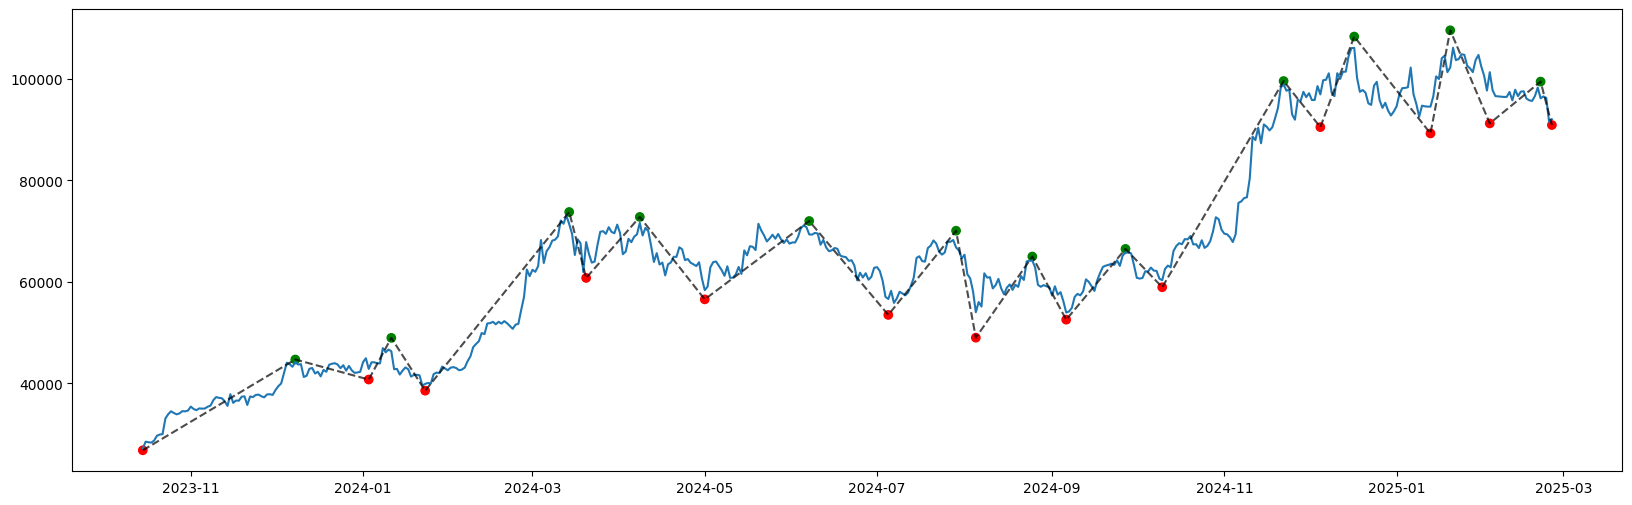

In [5]:
zz = ZigZag()
zz_points = zz.fit(df)
zz_points


plt.figure(figsize=(20, 6))
plt.plot(df["Close"], label="Price")
if zz_points:
    pivot_dates, pivot_prices, pivot_labels = zip(*zz_points)
    plt.scatter(pivot_dates, pivot_prices, c=["green" if label == "High" else "red" for label in pivot_labels], label="Pivots")
    plt.plot(pivot_dates, pivot_prices, color="black", linestyle="dashed", alpha=0.7)

plt.show()

#### Directional Change


In [6]:
from scripts.directional_change import DirectionalChange

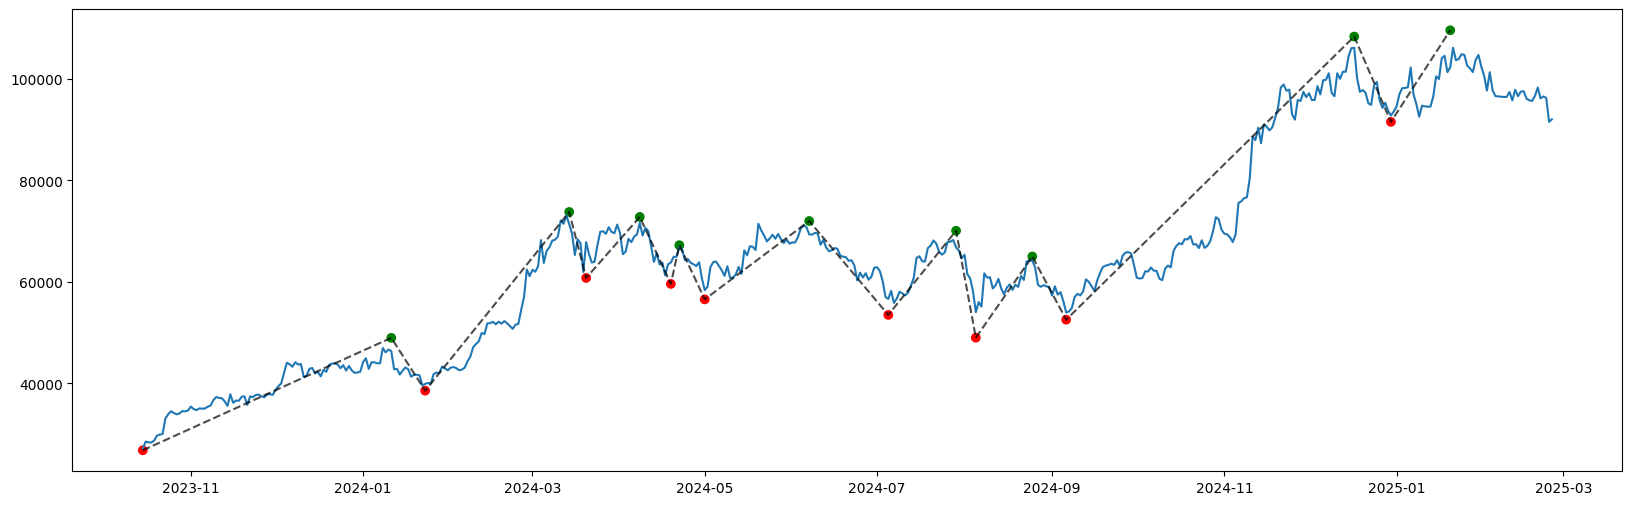

In [7]:
dc = DirectionalChange(threshold=10)
dc_points = dc.fit(df)

plt.figure(figsize=(20, 6))
plt.plot(df["Close"], label="Price")
if dc_points:
    pivot_dates, pivot_prices, pivot_labels = zip(*dc_points)
    plt.scatter(pivot_dates, pivot_prices, c=["green" if label == "High" else "red" for label in pivot_labels], label="Pivots")
    plt.plot(pivot_dates, pivot_prices, color="black", linestyle="dashed", alpha=0.7)

plt.show()